# Time Series Forecasting Evaluation Tool
Melissa Medeiros - October 29, 2018

#### Scenario: 
We have created a forecast (of some metric that we care about) for the next n months.  We want to evaluate the forecast's performance over time, and adjust our expectations as we collect more information.

#### Outline:
1. Compare forecast vs actuals to date 
2. Compare ^ against a baseline forecast (sometimes we get too fancy in our forecasting)
3. Update both forecasts given new information
4. Make next-period predictions

## Setup
Import packages and set up global variables

In [1]:
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload 

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default chart size for notebook

In [2]:
# set global variables
CURRENT_DATE = pd.to_datetime('1970-9-13') # replace with dt.datetime.now() in real app
SERIES_NAME = 'NYC Mumps' 

In [3]:
# find global variable
# note: this logic only works for a monthly frequency! 
# need a test to determine the period interval and then select correct method
LAST_COMPLETE_PERIOD = CURRENT_DATE - dt.timedelta(days=CURRENT_DATE.day)
LAST_COMPLETE_PERIOD

Timestamp('1970-08-31 00:00:00')

## Assess forecast performance to date
Visually compare the forecast to actuals (to-date). Calculate overall error rate and errors for each observation.

#### Get forecast and actuals

In [4]:
# get forecast
forecast = pd.read_csv('data/forecast_1970-1972.csv', index_col=0, converters={'period':pd.to_datetime})
forecast.columns = ['period','forecast']
forecast.head()

,period,forecast
0,1970-01-01,431.728260
1,1970-02-01,472.232504
2,1970-03-01,679.814417
3,1970-04-01,694.880277
4,1970-05-01,710.438670


In [5]:
# get actuals to date
actuals = pd.read_csv('data/actuals_1970-1972.csv', index_col=0, 
                      converters={'month':pd.to_datetime}).reset_index(drop=True)

actuals.columns=['period','actuals']

# only keep complete months in the past - no cheating!
actuals = actuals[actuals.period < LAST_COMPLETE_PERIOD]
actuals.tail()

,period,actuals
3,1970-04-01,527
4,1970-05-01,463
5,1970-06-01,429
6,1970-07-01,300
7,1970-08-01,147


In [6]:
# check that start of actuals == start of forecast, adjust if necessary
if actuals.period.min() < forecast.period.min():
    actuals = actuals[actuals.period >= forecast.period.min()] 
elif forecast.period.min() < actuals.period.min():
    forecast = forecast[forecast.period >= actuals.period.min()]

# confirm this is true
start_test = actuals.period.min() == forecast.period.min()

print('Actual start {} == forecast start {}? \n{}'.format(actuals.period.min().strftime('%Y-%m-%d'), 
                                                          forecast.period.min().strftime('%Y-%m-%d'), start_test))

Actual start 1970-01-01 == forecast start 1970-01-01? 
True


#### Plot forecast and actuals

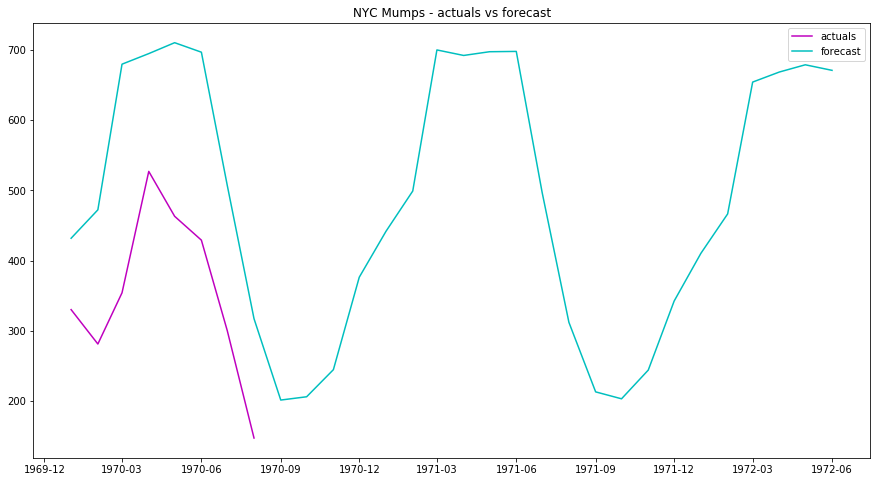

In [7]:
# plot forecast vs actuals
plt.plot(actuals.period, actuals.actuals, 'm-')
plt.plot(forecast.period, forecast.forecast, 'c-')
plt.title('{} - actuals vs forecast'.format(SERIES_NAME))
plt.legend()
plt.show()

#### Calculate the forecast's error rates 
Both overall and for each observation

In [8]:
# create df to hold forecast and actuals to date - will append performance info
forecast_results = actuals.merge(forecast)

In [9]:
# get the forecast's mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(forecast_results.actuals, forecast_results.forecast)
print('Overall mean absolute percentage error: {:.2f}%'.format(mape))

Overall mean absolute percentage error: 65.42%


In [10]:
# get the forecast's absolute percentage error for each observation
def absolute_percentage_error(row):
    return abs(row['actuals'] - row['forecast'])/row['actuals']
    
forecast_results['ape'] = forecast_results.apply(absolute_percentage_error, axis=1)
forecast_results

,period,actuals,forecast,ape
0,1970-01-01,330,431.728260,0.308267
1,1970-02-01,281,472.232504,0.680543
2,1970-03-01,354,679.814417,0.920380
3,1970-04-01,527,694.880277,0.318558
4,1970-05-01,463,710.438670,0.534425
5,1970-06-01,429,696.896213,0.624467
6,1970-07-01,300,507.015044,0.690050
7,1970-08-01,147,317.095778,1.157114


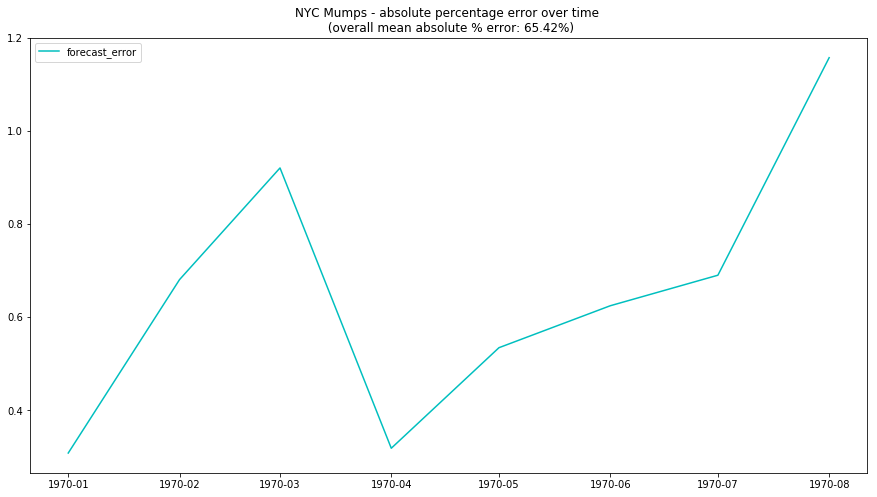

In [11]:
# plot error over time
plt.plot(forecast_results.period, forecast_results.ape, 'c-', label='forecast_error')
plt.title('{} - absolute percentage error over time \n (overall mean absolute % error: {:.2f}%)'.format(SERIES_NAME, mape))
plt.legend()
plt.show()

## Compare forecast to baseline forecast
A "baseline" forecast is a simple forcasting method that our more sophisticated forecasting method(s) will try to beat. 

For this example we are using a YoY moving average (3) model: Next January's forecast is the average of the previous 3 Januaries' values.

In [12]:
# import the baseline forecast
baseline_forecast = pd.read_csv('data/yoy_ma_forecast_1970-1972.csv', converters={'period':pd.to_datetime})
baseline_forecast.columns = ['period','baseline_forecast']
baseline_forecast.head()

,period,baseline_forecast
0,1970-01-01,224.333333
1,1970-02-01,252.666667
2,1970-03-01,369.333333
3,1970-04-01,512.333333
4,1970-05-01,546.333333


#### Plot actuals vs both forecasts

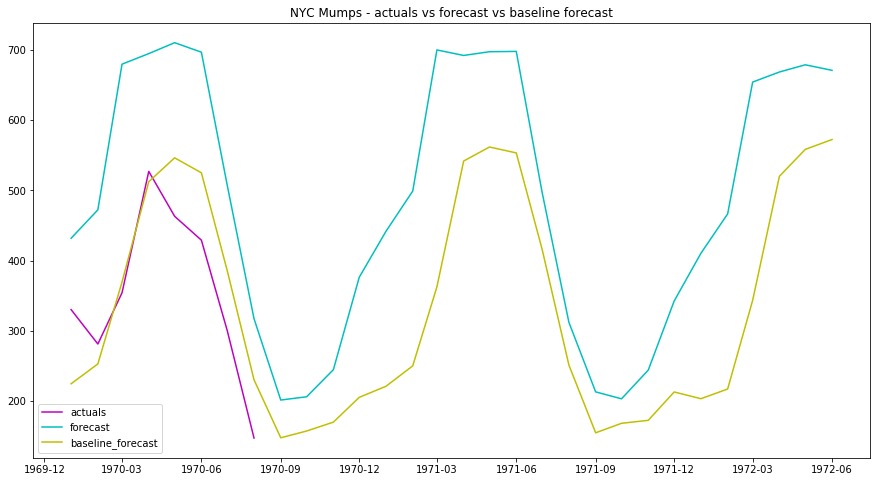

In [13]:
# plot forecast vs actuals
plt.plot(actuals.period, actuals.actuals, 'm-')

plt.plot(forecast.period, forecast.forecast, 'c-')
plt.plot(baseline_forecast.period, baseline_forecast.baseline_forecast, 'y-')
plt.title('{} - actuals vs forecast vs baseline forecast'.format(SERIES_NAME))
plt.legend()
plt.show()

#### Calculate the baseline forecast's error rates

In [14]:
# add baseline to forecast_results df
forecast_results = forecast_results.merge(baseline_forecast, how='left')

# get overall error for baseline forecast
baseline_mape = mean_absolute_percentage_error(forecast_results.actuals, forecast_results.baseline_forecast)
print('Overall mean absolute percentage error: {:.2f}%'.format(baseline_mape))

Overall mean absolute percentage error: 21.81%


In [15]:
# get baseline forecast error for each observation
# it's a shame to repeat this function just because the cols have different names
def get_baseline_absolute_percentage_error(row): 
    return abs(row['actuals'] - row['baseline_forecast'])/row['actuals']
    
forecast_results['baseline_ape'] = forecast_results.apply(get_baseline_absolute_percentage_error, axis=1)
forecast_results

,period,actuals,forecast,ape,baseline_forecast,baseline_ape
0,1970-01-01,330,431.728260,0.308267,224.333333,0.320202
1,1970-02-01,281,472.232504,0.680543,252.666667,0.100830
2,1970-03-01,354,679.814417,0.920380,369.333333,0.043315
3,1970-04-01,527,694.880277,0.318558,512.333333,0.027830
4,1970-05-01,463,710.438670,0.534425,546.333333,0.179986
5,1970-06-01,429,696.896213,0.624467,525.000000,0.223776
6,1970-07-01,300,507.015044,0.690050,385.333333,0.284444
7,1970-08-01,147,317.095778,1.157114,230.000000,0.564626


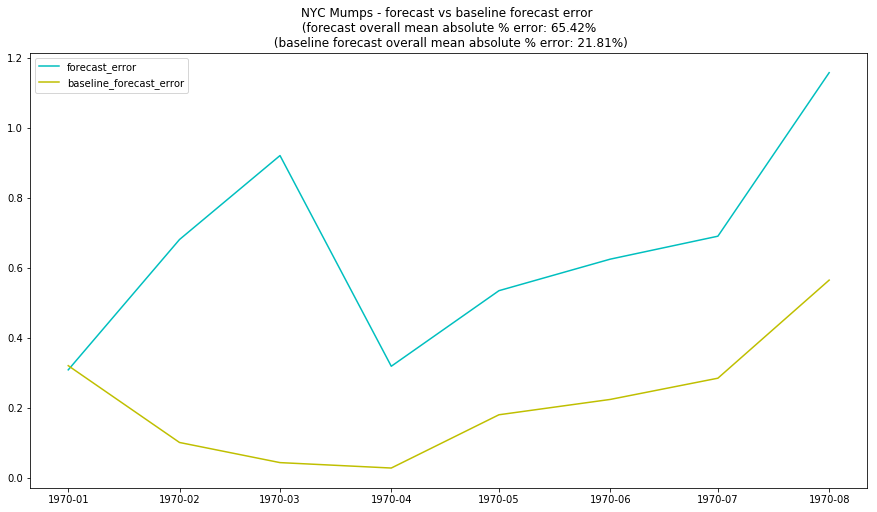

In [16]:
# plot error over time
plt.plot(forecast_results.period, forecast_results.ape, 'c-', label='forecast_error')
plt.plot(forecast_results.period, forecast_results.baseline_ape, 'y-', label='baseline_forecast_error')
plt.title('{} - forecast vs baseline forecast error \n (forecast overall mean absolute % error: {:.2f}% \n (baseline forecast overall mean absolute % error: {:.2f}%)'.format(SERIES_NAME, mape, baseline_mape))
plt.legend()
plt.show()

## Update both forecasts with current information
Rerun underlying models with up-to-date data

In [17]:
# get historicals - these are the actual observations before our forecasting time period
# they were used to train the original models & we will need them to revise the forecasts
historicals = pd.read_csv('data/historicals.csv', converters={'month':pd.to_datetime})
historicals.columns = ['period','historicals']
historicals.tail()

,period,historicals
499,1969-08-01,283
500,1969-09-01,158
501,1969-10-01,223
502,1969-11-01,212
503,1969-12-01,333


In [18]:
# training data set = historical + actuals (to-date)
training = pd.concat([historicals, actuals.rename(columns={'actuals':'historicals'})], axis=0).reset_index(drop=True)

In [19]:
# get # of remaining predictions to make
num_preds = len(forecast) - len(actuals)
num_preds

22

### Update forecast
In this case, we are updating a SARIMA model with pre-selected parameter values

In [20]:
# run the model with all training data
import statsmodels.api as sm

# model parameters - constant from original forecast
# ideally we would grab the model object and pass that new data
p, q, P, Q = [10,11,4,1]
d, D, s = [2,1,12]

new_model=sm.tsa.statespace.SARIMAX(training.historicals, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=False)

/Users/melissamedeiros/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
# get forecasted values
new_forecast = new_model.forecast(num_preds) # vs .predict()?

# create df of newly forecasted values
new_period = sorted(list(set(forecast.period.values) - set(actuals.period.values)))
new_forecast = pd.DataFrame({'period':new_period, 'new_forecast':new_forecast.values})

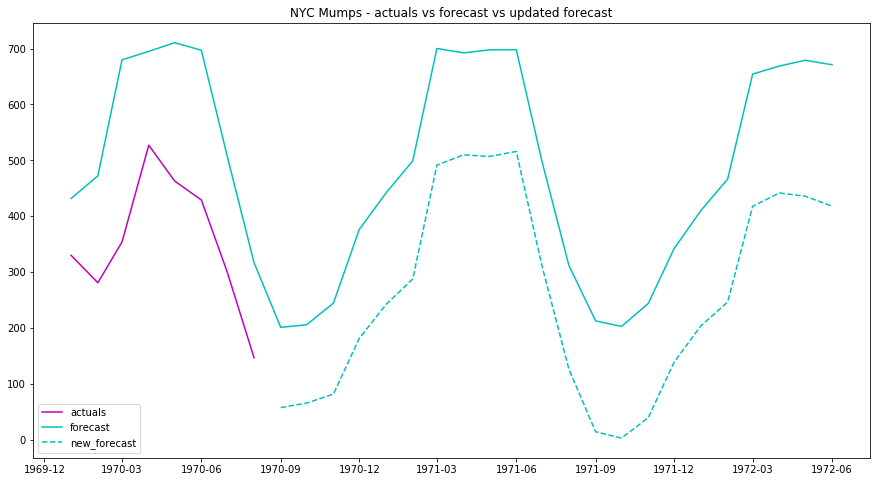

In [22]:
# plot actuals vs forecast vs updated forecast
plt.plot(actuals.period, actuals.actuals, 'm-')
plt.plot(forecast.period, forecast.forecast, 'c-')
plt.plot(new_forecast.period, new_forecast.new_forecast, 'c--')
plt.title('{} - actuals vs forecast vs updated forecast'.format(SERIES_NAME))
plt.legend()
plt.show()

### Update baseline forecast
The baseline forecast is a YoY moving average model using 3 years' previous values.

In [23]:
import math

def get_new_baseline(training_list, ma, num_pred):
    '''
    Get updated baseline model predictions for the remaining time periods in original forecast
    
    training_list: list of all previous actual values (ending with most recent period)
    ma: the # of YOY values to use in moving average calculation
    num_pred: the number of predictions to make (the # of remaining time periods in original forecast)
    '''
    
    # list to hold new baseline forecast values
    new_baseline = []
    
    # determine number of years to forecast
    # note: since this is yoy method we generate forecasts in complete years
    num_years = math.ceil(num_preds/12)
    
    for year in range(num_years):
        # keep the last ma years of data in the training list
        training_list = training_list[-12*ma:] 
        
        # reshape and get 3 year mean
        new_preds = np.mean(np.array(training_list).reshape(-1, 12), axis=0)
        
        # add new_preds to baselines AND the training list (to train future years)
        new_baseline.extend(new_preds)
        training_list.extend(new_preds)
        
    # only keep the # of predictions we need
    new_baseline = new_baseline[:num_preds]
        
    return new_baseline

In [24]:
# get the new predictions from the baseline forecast
new_baseline_preds = get_new_baseline(list(training.historicals), 3, num_preds)

# get new baseline forecast with dates
new_baseline_forecast = pd.DataFrame({'period':new_period, 'new_baseline_forecast':new_baseline_preds})
new_baseline_forecast.head()

,new_baseline_forecast,period
0,147.333333,1970-09-01
1,157.000000,1970-10-01
2,169.666667,1970-11-01
3,205.000000,1970-12-01
4,256.000000,1971-01-01


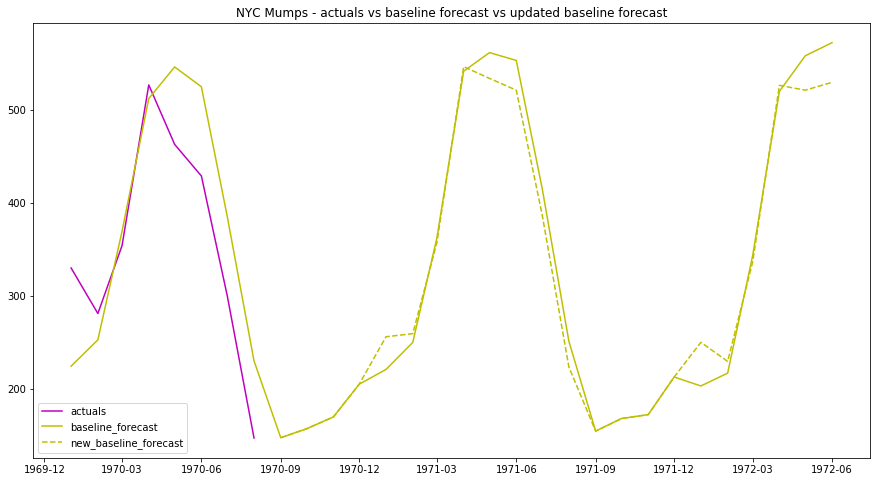

In [25]:
# plot adjusted baseline forecast
# plot actuals vs baseline forecast vs updated baseline forecast
plt.plot(actuals.period, actuals.actuals, 'm-')
plt.plot(baseline_forecast.period, baseline_forecast.baseline_forecast, 'y-')
plt.plot(new_baseline_forecast.period, new_baseline_forecast.new_baseline_forecast, 'y--')
plt.title('{} - actuals vs baseline forecast vs updated baseline forecast'.format(SERIES_NAME))
plt.legend()
plt.show()

### Compare updated forecasts

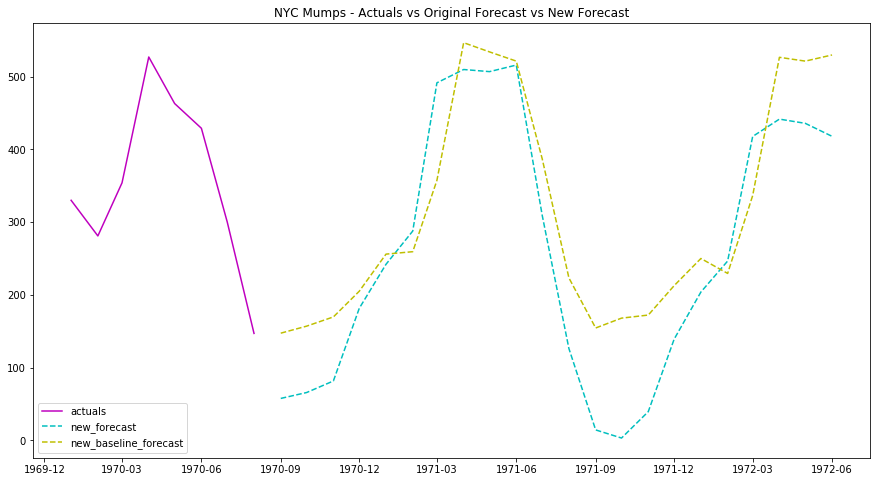

In [26]:
# plot actuals vs update forecast vs updated baseline forecast
plt.plot(actuals.period, actuals.actuals, 'm-')
plt.plot(new_forecast.period, new_forecast.new_forecast, 'c--')
plt.plot(new_baseline_forecast.period, new_baseline_forecast.new_baseline_forecast, 'y--')
plt.title('{} - Actuals vs Original Forecast vs New Forecast'.format(SERIES_NAME))
plt.legend()
plt.show()

#### Highlight next-period predictions

In [27]:
# show next period prediction for forecast
print('Adjusted forecast for {}: {:.2f}'.format(new_forecast['period'][0].strftime('%Y-%m-%d'), 
                                                new_forecast['new_forecast'][0]))

Adjusted forecast for 1970-09-01: 57.62


In [28]:
# show next period prediction for baseline forecast
print('Adjusted baseline forecast for {}: {:.2f}'.format(new_baseline_forecast['period'][0].strftime('%Y-%m-%d'), 
                                                                new_baseline_forecast['new_baseline_forecast'][0]))

Adjusted baseline forecast for 1970-09-01: 147.33


# Appendix

Known issues:
- LAST_COMPLETE_PERIOD method only works for a monthly frequency (should work for other common forecasting intervals such as daily and weekly) 
- Repeat function: get_aboslute_percentage_error and get_baseline_absolute_percentage_error
- Not using the actual original model object from previous work - when those parameters change, this will need to be manually updated
- SARIMA model is not optimized 
- Check difference between SARIMAX's .forecast() and .predict()